# Zagadnienie: rozpoznawanie mowy

Tematem, którym dotychczas nie zajmowaliśmy się na zajęciach, a stanowi bardzo istotną dziedzinę uczenia maszynowego w akustyce jest rozpoznawanie mowy. Jest to też dobra tematyka do pokazania możliwości sztucznych sieci neuronowych - już prosta sieć, wykorzystująca jedynie podstawowe rodzaje warstw pozwala osiągnąć względnie dobre rezultaty.

Do rozpoznawania mowy stosowane są często tzw. *filterbank features*, czyli cechy wyznaczane są jako wartości energii sygnału w poszczególnych pasmach w kolejnych ramkach sygnału. Od spektrogramu różnią się tym, że pasma wyznaczane są przez banki filtrów, czyli zbiory filtrów o zadanych parametrach. Najczęściej stosowanym bankiem filtrów jest bank filtrów melowych, który poznaliśmy przy okazji omawiania MFCC - dla przypomnienia, tworzony przez filtry trójkątne o szerokości zależnej od częstotliwości środkowej filtra:

<img src="https://www.researchgate.net/profile/Yusnita-Mohd-Ali/publication/288632263/figure/fig1/AS:613909065121800@1523378735077/Mel-filter-banks-basis-functions-using-20-Mel-filters-in-the-filter-bank.png" alt="Bank filtrów melowych" width="800"/>

Po zlogarytmowaniu otrzymanych wartości otrzymujemy melspektrogram, który może posłużyć do późniejszego wyznaczenia MFCC - wystarczy zastosować transformację kosinusową.

Oba rodzaje cech znajdują zastosowanie w rozpoznawaniu mowy - poniżej przykład, jak różnią się one pomiędzy sobą (na górze melspektrogram, na dole zestaw MFCC dla tego samego sygnału).

<img src="https://haythamfayek.com/assets/posts/post1/filter_banks.jpg" alt="Melspektrogram" width="800"/>

.

<img src="https://haythamfayek.com/assets/posts/post1/mfcc.jpg" alt="MFCC" width="800"/>

Źródło obrazów: https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html

Naszą pierwszą sieć służącą do rozpoznawania mowy będziemy uczyć na melspektrogramach. Przed ich ekstrakcją, przeprowadzona została filtracja filtrem preemfazy, który ma na celu uwydatnienie składowych o wyższych częstotliwościach. Wszystkie operacje zostały przeprowadzone przy użyciu biblioteki [python_speech_features](http://python-speech-features.readthedocs.io/).

Dane, które będziemy wykorzystywać pochodzą z bazy [TensorFlow Speech Commands v0.02](http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz) i zawierają 35 słów:

[Yes, No, Up, Down, Left, Right, On, Off, Stop, Go, Zero, One, Two, Three, Four, Five, Six, Seven, Eight, Nine, Bed, Bird, Cat, Dog, Happy, House, Marvin, Sheila, Tree, Wow]

Sygnały mają długość 1s - wszystkie krótsze zostały symetrycznie uzupełnione zerami, by uzyskać stałą długość sygnału.

Żeby zredukować czas potrzebny na trening sieci oraz ograniczyć rozmiar danych, będziemy analizować tylko 300 losowo wybranych nagrań każdego ze słów. W praktyce powinno wykorzystywać się możliwe duży zbiór danych - możesz samodzielnie wyliczyć cechy ze wszystkich sygnałów w bazie i wykorzystać je do treningu sieci.

# Sieć gęsta (*dense*, FC - *fully connected*)

Zainspirowana połączeniami nerwowymi w mózgu koncepcja sztucznych sieci neuronowych (ANN, *artifical neural networks*; częściej po prostu NN) sięga lat 40. XX w., a ich dynamiczny rozwój w ostatnich latach zawdzięczamy rosnącym możliwościom sprzętowym i dużym ilościom danych pozwalającym na efektywne uczenie sieci. Zagadnienia uczenia maszynowego związane z sieciami neuronowymi określa się mianem uczenia głębokiego (DL, *deep learning*). Pozwalają one uzyskać bardzo dobre rezultaty w sytuacji, gdy standardowe modele klasyfikacyjne są zbyt proste i nie radzą sobie z danym zagadnieniem.

Na początek zapoznamy się z najbardziej podstawowym rodzajem sieci neuronowej - siecią typu *feed-forward* z warstwami *fully connected*, czyli tzw. perceptronem.

Warstwy typu *fully connected* (FC) cechują się tym, że każdy neuron wejściowy warstwy połączony jest z każdym neuronem wyjściowym warstwy poprzedniej. Każde takie połączenie ma określoną wagę - te wagi to parametry sieci, które modyfikowane są podczas jej treningu.

![caption](https://4.bp.blogspot.com/-eTAX5ZojPwE/WrOuZWgFBKI/AAAAAAABCsc/YXLYgbVT4NE-hf2SoCvhHFdH3ocps9cdgCLcBGAs/s320/Capture.PNG)

Sieć *feed-forward* cechuje się tym, że przepływ informacji pomiędzy warstwami jest jednokierunkowy i nie występują sprzężenia zwrotne - wyjście danej warstwy jest zawsze połączone tylko z wejściem kolejnej warstwy.

# Biblioteki

Do implementacji sieci neuronowych w Pythonie stosowane są najczęściej dwa pakiety: [TensorFlow](https://www.tensorflow.org/tutorials?hl=pl) i [PyTorch](https://pytorch.org/tutorials/beginner/basics/intro.html). My będziemy używać tego drugiego.

Zarówno TensorFlow, jak i PyTorch, zapewniają bardzo dużą swobodę w definiowaniu architektury sieci. Jest to ich duża zaleta, jednak dla początkujących osób może być to trochę problematyczne i przytłaczające - każda klasa musi być odpowiednio zdefiniowana, trzeba samodzielnie napisać funkcje, które będą wykorzystywane do wczytywania danych i treningu sieci itd. Żeby ułatwić pracę użytkownikom mniej zaawansowanym i ustrukturyzować kod, stworzone zostały upraszczające pracę nakładki na oba pakiety. W przypadku PyTorcha najczęściej używane są dwie z nich: [Ignite](https://pytorch-ignite.ai/tutorials/beginner/01-getting-started/) i [Lightning](https://lightning.ai/docs/pytorch/stable/starter/introduction.html). Skorzystamy z Ignite, łatwiej będzie nam w ten sposób prześledzić poszczególne etapy.

W środowisku Colab musimy doinstalować Ignite; na własnym komputerze konieczna będzie wcześniejsza instalacja PyTorcha:

In [ ]:
# ! pip install torch==2.5.1
# ! pip install pytorch-ignite==0.5.1

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from ignite.engine import create_supervised_trainer, create_supervised_evaluator, Events
from ignite.metrics import Loss, Accuracy
from ignite.handlers.tqdm_logger import ProgressBar
from ignite.handlers import FastaiLRFinder

Dane znajdują się na dysku Google (link na upelu) - najszybciej będzie utworzyć na swoim dysku skrót i podać odpowiednią ścieżkę, aby je wczytać. Dla pracujących na własnych komputerach w folderze znajduje się zip do pobrania.

In [17]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [2]:
folder = '' #zmodyfikuj ścieżkę odpowiednio do lokalizacji plików

feats = np.load(folder+'melspec_feats.npy')
labels = np.load(folder+'labels.npy')

Macierz `feats` jest trójwymiarowa (liczba sygnałów $\times$ liczba ramek $\times$ liczba filtrów). Zwykła sieć typu *feed-forward* potrzebuje mieć dane opisujące pojedynczy obiekt podane w postaci wektora, a nie obrazu (macierzy 2D). Używamy więc funkcji reshape, żeby zmienić kształt danych na odpowiedni (liczba sygnałów $\times$ liczba cech, gdzie liczba cech $=$ liczba ramek $\cdot$ liczba filtrów)

Dane podzielimy na trzy zbiory: uczący, walidacyjny i testowy, w proporcji 0,8 : 0,1 : 0,1. Zbiór uczący i testowy mają takie samo zastosowanie jak zawsze - uczący wykorzystywany jest do treningu modelu, a testowy do jego oceny. Zbiór walidacyjny posłuży nam do ewaluacji modelu podczas treningu.

In [3]:
feats = feats.reshape(feats.shape[0], -1)
feats = feats.astype(np.float32)

X_train, X_val_test, y_train, y_val_test = train_test_split(feats, labels, random_state=42, stratify=labels, train_size=0.8)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, random_state=42, stratify=y_val_test, train_size=0.5)

Biblioteki do pracy z sieciami neuronowymi korzystają z własnego typu danych - [tensorów](https://pytorch.org/tutorials/beginner/introyt/tensors_deeper_tutorial.html), które zachowują się podobnie jak macierze numpy. Musimy więc zamienić macierze z cechami oraz wektor etykiet na tensory i utworzyć z nich TensorDataset, czyli zbiór danych w formacie dostosowanym do użycia w sieci neuronowej.

In [4]:
trainset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
valset = TensorDataset(torch.tensor(X_val), torch.tensor(y_val))
testset = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))

# batch, epoka, iteracja

Na początku wagi dla poszczególnych neuronów są dobrane losowo lub za pomocą specjalnych algorytmów (np. Kaiming, Xavier), a w procesie uczenia są uaktualniane (o tym w jaki sposób za chwilę) tak, aby zminimalizować błąd popełniany przez sieć. Uczenie sieci neuronowej przebiega **epokami** - epoka to jedno przejście wszystkich danych uczących przez architekturę sieci, podczas którego uaktualniane są wagi poszczególnych neuronów. Zbiory danych treningowych są zazwyczaj bardzo duże i niemożliwe jest (z powodu ograniczonych zasobów obliczeniowych) załadowanie całego datasetu na raz - oprócz reprezentacji danych trzymamy w pamięci parametry modelu, czyli wagi wszystkich neuronów.

Dlatego dzielony jest on na ***batche*** („wsady”), czyli po prostu mniejsze podzbiory, a epoka rozbija się na **iteracje** - jedna iteracja to aktualizacja wag na podstawie danych z jednego *batcha*. Podział na *batche* pozwala na przetworzenie przez sieć nawet bardzo dużych zbiorów danych.

Epoka kończy się po przejściu przez cały zbiór danych - przykładowo, jeśli nasz zbiór uczący zawiera $200000$ nagrań, a w pamięci zmieści się na raz $200$ (czyli `batch_size=200`), to jedna epoka będzie składała się z $1000$ iteracji. W każdej z nich wagi neuronów będą uaktualniane na podstawie 200-elementowego podzbioru danych treningowych.

Rozmiar batcha i liczba epok są jednymi z podstawowych hiperparametrów określanych w treningu sieci. Większy *batch size* pozwoli załadować więcej danych na raz (szybsze uczenie), jednak zbyt duży może prowadzić do słabej zdolności modelu do generalizacji (gradienty dla każdego *batcha* są „uśrednione” dla zawartych w nim danych  - więcej na ten temat np. [w tym poście](https://medium.com/mini-distill/effect-of-batch-size-on-training-dynamics-21c14f7a716e) lub [tym artykule](https://arxiv.org/pdf/1609.04836)).


# Budowa pipeline'u

## DataLoader

Przy okazji SVM poznaliśmy pipeline'y - ta koncepcja przyda nam się przy sieciach. Skoro dzielimy zbiór danych na *batche*, a uczenie przebiega epokami, będziemy wielokrotnie powtarzać te same operacje ładowania danych, treningu i ewaluacji (po każdej epoce lub kilku). Do tej pierwszej operacji potrzebny nam będzie tzw. **DataLoader**, czyli obiekt klasy odpowiadającej za logikę wczytywania i ewentualnego preprocessingu danych.

Stworzymy teraz osobny DataLoader dla każdego zbioru danych:

In [5]:
train_loader = DataLoader(trainset, batch_size=256)
val_loader = DataLoader(valset, batch_size=256)
test_loader = DataLoader(testset, batch_size=256)

## Architektura sieci

Po wczytaniu i odpowiednim przygotowaniu danych możemy przejść do definicji klasy, w której będzie zapisana architektura sieci. Korzystamy z szablonu `nn.Module`, który zawiera dwie podstawowe funkcje:
- `init`: określamy, jakie warstwy będą występowały w sieci (ich rodzaj i rozmiar).

    Dzisiaj będziemy używać jedynie warstw *fully connected*. Będą to zwykłe warstwy liniowe, które tworzy się używając klasy `nn.Linear`; jako parametry musimy podać wymiary warstwy: liczbę neuronów wejściowych oraz wyjściowych.

    Liczba wejść kolejnej warstwy musi być taka sama, jak liczba wyjść poprzedniej. Liczba wejść pierwszej warstwy musi pasować do rozmiaru danych uczących. W przypadku sieci klasyfikującej liczba wyjść ostatniej warstwy powinna być równa liczbie klas w zbiorze danych. Pomiędzy nimi dodamy warstwę ukrytą, dla której możemy dowolnie wybrać liczbę neuronów.

- `forward`: tutaj określamy kolejność warstw, a tym samym kierunek przepływu danych wewnątrz sieci. Do tej funkcji jako `x` podawana będzie paczka danych (*batch*).

    Sieć klasyfikująca zwraca dane ciągłe, podobnie jak poznane wcześniej modele regresyjne. Musimy więc określić, w jaki sposób wartości zwracane przez sieć zostaną przeliczone na prawdopodobieństwa dla poszczególnych klas. Robimy to za pomocą **funkcji aktywacji** w ostatniej warstwie.

     Jest wiele funkcji aktywacji o różnych zastosowaniach - ich zadaniem jest wprowadzenie nieliniowości do modelu. Zajmiemy się nimi na kolejnych zajęciach, a dziś użyjemy funkcji [LogSoftmax](https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html), czyli logarytmowanej znormalizowanej funkcji wykładniczej. Softmax pozwala uzyskać na wyjściu sieci wektor prawdopodobieństw przynależności obiektu do każdej z klas, natomiast zastosowanie logarytmu jest szybsze pod względem numerycznym.

In [6]:
class Net(nn.Module): # dziedziczenie po klasie nn.Module
    def __init__(self,
                 n_features, #liczba cech = pasm częstotliwości * ramek
                 hidden_in,
                 hidden_out, # liczba neuronów w warstwie pośredniej
                 n_classes # liczba klas w zbiorze
                 ):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_features, hidden_in)
        self.fc2 = nn.Linear(hidden_in, hidden_out)
        self.fc3 = nn.Linear(hidden_out, n_classes)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return self.softmax(x)

## Funkcja straty

Musimy jeszcze ustalić, jakie będzie kryterium uczenia się sieci - do czego będzie ona dążyć, czyli zmienną `criterion`. Użyjemy funkcji straty **NLLLoss** (*negative log likelihood loss*) - im mniejszą wartość będzie przyjmować, tym mniejsza różnica pomiędzy klasą rzeczywistą a predykcją sieci. NLLLoss jest odpowiednikiem entropii krzyżowej w sytuacji, gdy prawdopodobieństwa są zlogarytmowane.

Przy okazji omawiania metryki *log loss* (straty logarytmicznej, inaczej nazywanej właśnie entropią krzyżową) wyliczaliśmy tzw. prawdopodobieństwa skorygowane. Wynikało to z tego, że binarne modele regresyjne mają tylko jedno wyjście, i prawdopodobieństwo mniejsze od zdefiniowanego progu oznaczało przynależność do klasy 0, a większe - do klasy 1.

W przypadku sieci neuronowej i klasyfikacji wieloklasowej mamy tyle wyjść, ile klas, nie trzeba więc liczyć prawdopodobieństw skorygowanych - każde wyjście zwraca prawdopodobieństwo przynależności obiektu do jednej, konkretnej klasy. W takim przypadku entropia krzyżowa jest liczona jako ujemna średnia logarytmiczna prawdopodobieństw zwróconych przez odpowiednie wyjścia (te, które odpowiadają rzeczywistym klasom rozważanych obiektów).

## Optymalizator

Kolejnym krokiem jest dobór optymalizatora (*optimizer*). Służy on do optymalizacji wag modelu, czyli zmieniania ich w taki sposób, żeby osiągnąć zadane kryterium, np. minimalną wartość NLLLoss.

W procesie uczenia wyliczany jest **gradient funkcji kosztu** - gradient jest uogólnieniem pojęcia pochodnej na wektor, zawiera wszystkie pochodne cząstkowe tego wektora. Gdy zbliżamy się do minimum funkcji, gradient zanika. Prześledźmy najpierw metodę gradientu prostego, która składa się z 5 kroków:
1. wyznaczenie gradientu funkcji kosztu,
2. wybranie losowych wartości parametrów (wag neuronów),
3. wyliczenie gradientu na podstawie wartości parametrów,
4. wyliczenie wielkości kroku, o który zmienimy wartości parametrów zgodnie ze wzorem: step size $=$ gradient $\cdot$ learning rate,
5. wyliczenie nowych wartości parametrów: new params $=$ old params $-$ step size,
6. powtarzanie kroków 3-5 do momentu uzyskania gradientu równego (bliskiego) 0.

Wielkość kroków podczas zmiany parametrów określana jest przez **współczynnik uczenia** (*learning rate*, LR). Im większy współczynnik, tym większe kroki są stosowane - to zapewnia szybszy proces optymalizacji wag (a w konsekwencji uczenia sieci), ale też powoduje ryzyko „przeskoczenia” nad wartością optymalną i może pogorszyć ostateczne rezultaty.

![caption](https://miro.medium.com/max/724/1*AqatzLelQw8LO9XuPCdfFw.png)

Z kolei zbyt mała wartość LR znacząco wydłuża proces uczenia, co również nie jest korzystne.

Jednym z najczęściej używanych optimizerów jest SGD, który wykorzystuje stochastyczny spadek gradientu (*stochastic gradient descent*). Metoda ta różni się od metody gradientu prostego tym, że nie korzysta się w niej z gradientu wyliczonego na całym zbiorze danych uczących, ponieważ jest to czaso- i kosztochłonne. Zamiast tego estymuje się wartość gradientu na podstawie losowo wybranego elementu ze zbioru danych - stąd nazwa stochastyczny.

Drugim parametrem optymalizatora jest moment (*momentum*), określający, z jaką wagą optymalizator będzie [brał pod uwagę gradienty z poprzedniej iteracji](https://paperswithcode.com/method/sgd-with-momentum).

## Urządzenie docelowe

Na koniec ładujemy nasz model na urządzenie, na którym będą przeprowadzane obliczenia: najpierw funkcją `torch.cuda.is_available()` sprawdzamy, czy jest dostępna karta graficzna. Jeżeli tak, to chcemy jej użyć (`device="cuda"`), jeżeli nie, to musimy zadowolić się procesorem (`device="cpu"`).

Przy konfigurowaniu własnego sprzętu, do prowadzenia obliczeń na karcie graficznej potrzebne będą specjalne sterowniki i API ([CUDA toolkit](https://docs.nvidia.com/cuda/cuda-quick-start-guide/)) i biblioteka do uczenia głębokiego cuDNN (*CUDA Deep Neural Network*). Colab umożliwia ograniczony czasowo dostęp do kart graficznych i ma już zainstalowane potrzebne biblioteki.

In [7]:
criterion = nn.NLLLoss()

# tworzymy sieć podając argumenty funkcji init
model = Net(n_features=feats.shape[1], #liczba cech = pasm częstotliwości * ramek
            hidden_in=256,
            hidden_out=120, # liczba neuronów w warstwie pośredniej
            n_classes=35 # liczba klas w zbiorze
        )

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model.to(device)  # ładujemy model przed stworzeniem optymalizatora
optimizer = torch.optim.SGD(model.parameters(), lr=1e-8, momentum=0.9)

cuda


W kolejnym kroku inicjalizujemy zmienne, w których będą zapisywane aktualne stany modelu i optimizera.

In [8]:
init_model_state = model.state_dict()
init_opt_state = optimizer.state_dict()

Za przeprowadzenie treningu i ewaluacji odpowiadać będą dwa obiekty:

* ***Trainer*** służy do uczenia sieci - przy inicjalizacji podajemy do niego model (sieć), funkcję straty (`criterion`) i urządzenie, na którym prowadzimy obliczenia (`device`). Wywołanie funkcji `run()` na trainerze odpowiada za całą logikę uczenia, a więc iteracyjne ładowanie danych w kolejnych epokach i aktualizację wag modelu w taki sposób, by dążyć do ekstremum zdefiniowanego kryterium (u nas do minimum, bo kryterium jest NLLLoss).

* ***Evaluator*** służy do walidacji sieci oraz do wyliczenia metryk na zbiorze testowym - **podczas jego użycia nie są aktualizowane wagi**. Przy inicjalizacji podajemy do niego model oraz metryki, które chcemy wyznaczyć.

Dodatkowo, żeby mieć podgląd, jak przebiega trening i na jakim jest etapie, użyjemy paska postępu wyświetlanego funkcją `ProgressBar`. Będzie on wyświetlał wyniki uzyskane na zbiorze uczącym podczas kolejnych epok.

In [9]:
trainer = create_supervised_trainer(model,
                                    optimizer,
                                    criterion,
                                    device=device)

evaluator = create_supervised_evaluator(model,
                                        metrics={"acc": Accuracy(), "loss": Loss(nn.NLLLoss())},
                                        device=device)

ProgressBar(persist=True).attach(trainer, output_transform=lambda x: {"batch loss": x})

c:\Users\mfox4\anaconda3\envs\pum\lib\site-packages\ignite\handlers\tqdm_logger.py:127: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


Uruchamiając trening sieci (`trainer.run()`) należy wybrać dataloader, z którego korzystamy i zdefiniować liczbę epok. Po każdej epoce przeprowadzimy ewaluację: wyznaczymy metryki uzyskiwane na zbiorze walidacyjnym - danych, których sieć „nie widziała” podczas treningu, więc uzyskane na nich metryki pozwalają ocenić proces uczenia.

Żeby przeprowadzić walidację w pakiecie ignite trzeba wywołać evaluator (jego metodę `run()`), do którego podaje się dane walidacyjne. Musi on być umieszczony w funkcji „podpiętej” pod trainer: definiujemy funkcję `log_validation_results` i używamy dekoratora (`@`) aby wywołać ją po zakończeniu epoki.

Po zakończonym treningu evaluator posłuży nam do wyliczenia metryk na zbiorze testowym - wystarczy, że użyjemy odpowiedniego dataloadera.

In [10]:
@trainer.on(Events.EPOCH_COMPLETED) #określamy, że walidacja ma być przeprowadzona po zakończeniu epoki
def log_validation_results(trainer):
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    print("Validation Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
          .format(trainer.state.epoch, metrics['acc'], metrics['loss']))

#trainer.run(trainloader, max_epochs=1000)
trainer.run(train_loader, max_epochs=50)

evaluator.run(test_loader)
print(evaluator.state.metrics)

Epoch [1/50]: [33/33] 100%|██████████, batch loss=6.07 [00:00<00:00]


Validation Results - Epoch: 1  Avg accuracy: 0.03 Avg loss: 5.69


Epoch [2/50]: [33/33] 100%|██████████, batch loss=6.06 [00:00<00:00]


Validation Results - Epoch: 2  Avg accuracy: 0.03 Avg loss: 5.68


Epoch [3/50]: [33/33] 100%|██████████, batch loss=6.04 [00:00<00:00]


Validation Results - Epoch: 3  Avg accuracy: 0.03 Avg loss: 5.66


Epoch [4/50]: [33/33] 100%|██████████, batch loss=6.02 [00:00<00:00]


Validation Results - Epoch: 4  Avg accuracy: 0.03 Avg loss: 5.65


Epoch [5/50]: [33/33] 100%|██████████, batch loss=6.01 [00:00<00:00]


Validation Results - Epoch: 5  Avg accuracy: 0.03 Avg loss: 5.63


Epoch [6/50]: [33/33] 100%|██████████, batch loss=5.99 [00:00<00:00]


Validation Results - Epoch: 6  Avg accuracy: 0.03 Avg loss: 5.62


Epoch [7/50]: [33/33] 100%|██████████, batch loss=5.97 [00:00<00:00]


Validation Results - Epoch: 7  Avg accuracy: 0.03 Avg loss: 5.60


Epoch [8/50]: [33/33] 100%|██████████, batch loss=5.96 [00:00<00:00]


Validation Results - Epoch: 8  Avg accuracy: 0.03 Avg loss: 5.59


Epoch [9/50]: [33/33] 100%|██████████, batch loss=5.94 [00:00<00:00]


Validation Results - Epoch: 9  Avg accuracy: 0.03 Avg loss: 5.57


Epoch [10/50]: [33/33] 100%|██████████, batch loss=5.93 [00:00<00:00]


Validation Results - Epoch: 10  Avg accuracy: 0.03 Avg loss: 5.56


Epoch [11/50]: [33/33] 100%|██████████, batch loss=5.92 [00:00<00:00]


Validation Results - Epoch: 11  Avg accuracy: 0.03 Avg loss: 5.55


Epoch [12/50]: [33/33] 100%|██████████, batch loss=5.9 [00:00<00:00] 


Validation Results - Epoch: 12  Avg accuracy: 0.03 Avg loss: 5.53


Epoch [13/50]: [33/33] 100%|██████████, batch loss=5.89 [00:00<00:00]


Validation Results - Epoch: 13  Avg accuracy: 0.03 Avg loss: 5.52


Epoch [14/50]: [33/33] 100%|██████████, batch loss=5.87 [00:00<00:00]


Validation Results - Epoch: 14  Avg accuracy: 0.03 Avg loss: 5.51


Epoch [15/50]: [33/33] 100%|██████████, batch loss=5.86 [00:00<00:00]


Validation Results - Epoch: 15  Avg accuracy: 0.03 Avg loss: 5.50


Epoch [16/50]: [33/33] 100%|██████████, batch loss=5.85 [00:00<00:00]


Validation Results - Epoch: 16  Avg accuracy: 0.03 Avg loss: 5.48


Epoch [17/50]: [33/33] 100%|██████████, batch loss=5.83 [00:00<00:00]


Validation Results - Epoch: 17  Avg accuracy: 0.03 Avg loss: 5.47


Epoch [18/50]: [33/33] 100%|██████████, batch loss=5.82 [00:00<00:00]


Validation Results - Epoch: 18  Avg accuracy: 0.03 Avg loss: 5.46


Epoch [19/50]: [33/33] 100%|██████████, batch loss=5.81 [00:00<00:00]


Validation Results - Epoch: 19  Avg accuracy: 0.03 Avg loss: 5.45


Epoch [20/50]: [33/33] 100%|██████████, batch loss=5.8 [00:00<00:00] 


Validation Results - Epoch: 20  Avg accuracy: 0.03 Avg loss: 5.44


Epoch [21/50]: [33/33] 100%|██████████, batch loss=5.78 [00:00<00:00]


Validation Results - Epoch: 21  Avg accuracy: 0.03 Avg loss: 5.42


Epoch [22/50]: [33/33] 100%|██████████, batch loss=5.77 [00:00<00:00]


Validation Results - Epoch: 22  Avg accuracy: 0.03 Avg loss: 5.41


Epoch [23/50]: [33/33] 100%|██████████, batch loss=5.76 [00:00<00:00]


Validation Results - Epoch: 23  Avg accuracy: 0.03 Avg loss: 5.40


Epoch [24/50]: [33/33] 100%|██████████, batch loss=5.75 [00:00<00:00]


Validation Results - Epoch: 24  Avg accuracy: 0.03 Avg loss: 5.39


Epoch [25/50]: [33/33] 100%|██████████, batch loss=5.73 [00:00<00:00]


Validation Results - Epoch: 25  Avg accuracy: 0.03 Avg loss: 5.38


Epoch [26/50]: [33/33] 100%|██████████, batch loss=5.72 [00:00<00:00]


Validation Results - Epoch: 26  Avg accuracy: 0.03 Avg loss: 5.37


Epoch [27/50]: [33/33] 100%|██████████, batch loss=5.71 [00:00<00:00]


Validation Results - Epoch: 27  Avg accuracy: 0.03 Avg loss: 5.36


Epoch [28/50]: [33/33] 100%|██████████, batch loss=5.7 [00:00<00:00] 


Validation Results - Epoch: 28  Avg accuracy: 0.03 Avg loss: 5.35


Epoch [29/50]: [33/33] 100%|██████████, batch loss=5.69 [00:00<00:00]


Validation Results - Epoch: 29  Avg accuracy: 0.03 Avg loss: 5.34


Epoch [30/50]: [33/33] 100%|██████████, batch loss=5.68 [00:00<00:00]


Validation Results - Epoch: 30  Avg accuracy: 0.03 Avg loss: 5.33


Epoch [31/50]: [33/33] 100%|██████████, batch loss=5.67 [00:00<00:00]


Validation Results - Epoch: 31  Avg accuracy: 0.03 Avg loss: 5.32


Epoch [32/50]: [33/33] 100%|██████████, batch loss=5.66 [00:00<00:00]


Validation Results - Epoch: 32  Avg accuracy: 0.03 Avg loss: 5.31


Epoch [33/50]: [33/33] 100%|██████████, batch loss=5.65 [00:00<00:00]


Validation Results - Epoch: 33  Avg accuracy: 0.03 Avg loss: 5.30


Epoch [34/50]: [33/33] 100%|██████████, batch loss=5.64 [00:00<00:00]


Validation Results - Epoch: 34  Avg accuracy: 0.03 Avg loss: 5.29


Epoch [35/50]: [33/33] 100%|██████████, batch loss=5.62 [00:00<00:00]


Validation Results - Epoch: 35  Avg accuracy: 0.03 Avg loss: 5.28


Epoch [36/50]: [33/33] 100%|██████████, batch loss=5.61 [00:00<00:00]


Validation Results - Epoch: 36  Avg accuracy: 0.03 Avg loss: 5.27


Epoch [37/50]: [33/33] 100%|██████████, batch loss=5.6 [00:00<00:00] 


Validation Results - Epoch: 37  Avg accuracy: 0.03 Avg loss: 5.26


Epoch [38/50]: [33/33] 100%|██████████, batch loss=5.59 [00:00<00:00]


Validation Results - Epoch: 38  Avg accuracy: 0.03 Avg loss: 5.25


Epoch [39/50]: [33/33] 100%|██████████, batch loss=5.58 [00:00<00:00]


Validation Results - Epoch: 39  Avg accuracy: 0.03 Avg loss: 5.24


Epoch [40/50]: [33/33] 100%|██████████, batch loss=5.57 [00:00<00:00]


Validation Results - Epoch: 40  Avg accuracy: 0.03 Avg loss: 5.23


Epoch [41/50]: [33/33] 100%|██████████, batch loss=5.56 [00:00<00:00]


Validation Results - Epoch: 41  Avg accuracy: 0.03 Avg loss: 5.22


Epoch [42/50]: [33/33] 100%|██████████, batch loss=5.55 [00:00<00:00]


Validation Results - Epoch: 42  Avg accuracy: 0.03 Avg loss: 5.21


Epoch [43/50]: [33/33] 100%|██████████, batch loss=5.55 [00:00<00:00]


Validation Results - Epoch: 43  Avg accuracy: 0.03 Avg loss: 5.21


Epoch [44/50]: [33/33] 100%|██████████, batch loss=5.54 [00:00<00:00]


Validation Results - Epoch: 44  Avg accuracy: 0.03 Avg loss: 5.20


Epoch [45/50]: [33/33] 100%|██████████, batch loss=5.53 [00:00<00:00]


Validation Results - Epoch: 45  Avg accuracy: 0.04 Avg loss: 5.19


Epoch [46/50]: [33/33] 100%|██████████, batch loss=5.52 [00:00<00:00]


Validation Results - Epoch: 46  Avg accuracy: 0.04 Avg loss: 5.18


Epoch [47/50]: [33/33] 100%|██████████, batch loss=5.51 [00:00<00:00]


Validation Results - Epoch: 47  Avg accuracy: 0.04 Avg loss: 5.17


Epoch [48/50]: [33/33] 100%|██████████, batch loss=5.5 [00:00<00:00] 


Validation Results - Epoch: 48  Avg accuracy: 0.04 Avg loss: 5.16


Epoch [49/50]: [33/33] 100%|██████████, batch loss=5.49 [00:00<00:00]


Validation Results - Epoch: 49  Avg accuracy: 0.04 Avg loss: 5.16


Epoch [50/50]: [33/33] 100%|██████████, batch loss=5.48 [00:00<00:00]


Validation Results - Epoch: 50  Avg accuracy: 0.04 Avg loss: 5.15
{'acc': 0.039047619047619046, 'loss': 5.1416289992559525}


Współczynnik uczenia może być dobierany w sposób automatyczny za pomocą funkcji [`FastaiLRFinder`](https://pytorch.org/ignite/generated/ignite.handlers.lr_finder.FastaiLRFinder.html). Definiujemy zakres poszukiwań (`start_lr`, `end_lr`) oraz to, czy LR ma być zwiększane wykładniczo (domyślnie), czy liniowo (`step_mode`). Dobrana wartość zależy od tego, ile wynosi `diverge_th` - poszukiwania najlepszej wartości współczynnika uczenia przerywane są w momencie, gdy zostanie spełnione kryterium *current loss $>$ diverge threshold $\cdot$ best loss*.

`diverge_th` może być dowolną liczbą nie mniejszą niż 1, domyślnie wynosi 5. Mniejsza wartość powoduje szybsze zakończenie poszukiwań najlepszego współczynnika uczenia, jednak jest to dość ryzykowne - jeżeli na początku poszukiwań trafimy na minimum lokalne, to szukanie zostanie zakończone. W praktyce może okazać się, że niezatrzymanie poszukiwań i zezwolenie na tymczasowe osiąganie większych wartości `current_loss` pozwoliłoby trafić na minimum globalne lub przynajmniej „lepsze” minimum lokalne, a tym samym lepiej dobrać wartość parametru i w konsekwencji przeprowadzić bardziej efektywny trening sieci.

Iteration: [32/33]  97%|█████████▋, batch loss=6.22 [00:00<00:00]

Suggested LR 3.053855508833417e-05


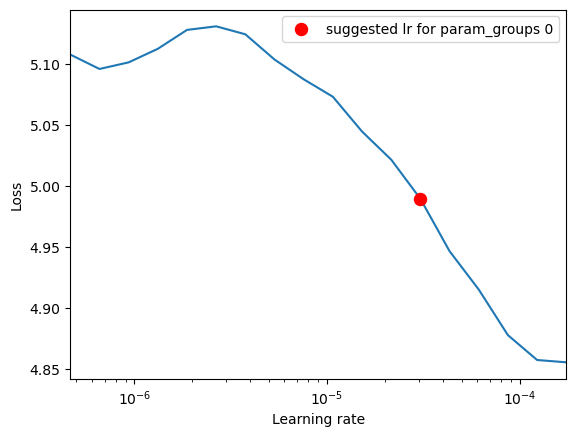

<Axes: xlabel='Learning rate', ylabel='Loss'>

Iteration: [33/33] 100%|██████████, batch loss=6.22 [00:10<00:00]

In [11]:
lr_finder = FastaiLRFinder()
to_save={'model': model, 'optimizer': optimizer}
with lr_finder.attach(trainer, to_save, diverge_th=1.05, start_lr=1e-8, end_lr=1e-3) as trainer_with_lr_finder:
    trainer_with_lr_finder.run(train_loader)

print("Suggested LR", lr_finder.lr_suggestion())
lr_finder.plot()

Po znalezieniu najlepszej wartości współczynnika uczenia trzeba ustawić tę wartość w optimizerze - robi się to funkcją apply_suggested_lr. Następnie trzeba ponownie przeprowadzić trening sieci.

Ponownie inicjalizujemy trainer - jeżeli tego nie zrobimy, to zamiast uczyć nową sieć neuronową będziemy kontynuować trening poprzedniej, co nie pozwoli nam dobrze przeanalizować wpływu parametru learning rate na proces uczenia.

In [12]:
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
# evaluator = create_supervised_evaluator(model, metrics={"acc": Accuracy(), "loss": Loss(nn.NLLLoss())}, device=device)
ProgressBar(persist=True).attach(trainer, output_transform=lambda x: {"batch loss": x})

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    print("Validation Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
          .format(trainer.state.epoch, metrics['acc'], metrics['loss']))

lr_finder.apply_suggested_lr(optimizer)
print('Training with suggested lr: ', optimizer.param_groups[0]['lr'])
#trainer.run(trainloader, max_epochs=1000)
trainer.run(train_loader, max_epochs=150)

evaluator.run(test_loader)
print(evaluator.state.metrics)

Training with suggested lr:  3.053855508833417e-05


Epoch [1/150]: [33/33] 100%|██████████, batch loss=3.88 [00:00<00:00]


Validation Results - Epoch: 1  Avg accuracy: 0.03 Avg loss: 3.90


Epoch [2/150]: [33/33] 100%|██████████, batch loss=3.6 [00:00<00:00]


Validation Results - Epoch: 2  Avg accuracy: 0.03 Avg loss: 3.65


Epoch [3/150]: [33/33] 100%|██████████, batch loss=3.56 [00:00<00:00]


Validation Results - Epoch: 3  Avg accuracy: 0.05 Avg loss: 3.59


Epoch [4/150]: [33/33] 100%|██████████, batch loss=3.52 [00:00<00:00]


Validation Results - Epoch: 4  Avg accuracy: 0.06 Avg loss: 3.56


Epoch [5/150]: [33/33] 100%|██████████, batch loss=3.49 [00:00<00:00]


Validation Results - Epoch: 5  Avg accuracy: 0.08 Avg loss: 3.52


Epoch [6/150]: [33/33] 100%|██████████, batch loss=3.46 [00:00<00:00]


Validation Results - Epoch: 6  Avg accuracy: 0.08 Avg loss: 3.50


Epoch [7/150]: [33/33] 100%|██████████, batch loss=3.44 [00:00<00:00]


Validation Results - Epoch: 7  Avg accuracy: 0.08 Avg loss: 3.47


Epoch [8/150]: [33/33] 100%|██████████, batch loss=3.42 [00:00<00:00]


Validation Results - Epoch: 8  Avg accuracy: 0.08 Avg loss: 3.45


Epoch [9/150]: [33/33] 100%|██████████, batch loss=3.39 [00:00<00:00]


Validation Results - Epoch: 9  Avg accuracy: 0.08 Avg loss: 3.43


Epoch [10/150]: [33/33] 100%|██████████, batch loss=3.38 [00:00<00:00]


Validation Results - Epoch: 10  Avg accuracy: 0.09 Avg loss: 3.41


Epoch [11/150]: [33/33] 100%|██████████, batch loss=3.36 [00:00<00:00]


Validation Results - Epoch: 11  Avg accuracy: 0.10 Avg loss: 3.39


Epoch [12/150]: [33/33] 100%|██████████, batch loss=3.34 [00:00<00:00]


Validation Results - Epoch: 12  Avg accuracy: 0.11 Avg loss: 3.37


Epoch [13/150]: [33/33] 100%|██████████, batch loss=3.32 [00:00<00:00]


Validation Results - Epoch: 13  Avg accuracy: 0.11 Avg loss: 3.35


Epoch [14/150]: [33/33] 100%|██████████, batch loss=3.31 [00:00<00:00]


Validation Results - Epoch: 14  Avg accuracy: 0.12 Avg loss: 3.34


Epoch [15/150]: [33/33] 100%|██████████, batch loss=3.29 [00:00<00:00]


Validation Results - Epoch: 15  Avg accuracy: 0.12 Avg loss: 3.32


Epoch [16/150]: [33/33] 100%|██████████, batch loss=3.27 [00:00<00:00]


Validation Results - Epoch: 16  Avg accuracy: 0.12 Avg loss: 3.30


Epoch [17/150]: [33/33] 100%|██████████, batch loss=3.26 [00:00<00:00]


Validation Results - Epoch: 17  Avg accuracy: 0.13 Avg loss: 3.29


Epoch [18/150]: [33/33] 100%|██████████, batch loss=3.25 [00:00<00:00]


Validation Results - Epoch: 18  Avg accuracy: 0.13 Avg loss: 3.28


Epoch [19/150]: [33/33] 100%|██████████, batch loss=3.23 [00:00<00:00]


Validation Results - Epoch: 19  Avg accuracy: 0.14 Avg loss: 3.26


Epoch [20/150]: [33/33] 100%|██████████, batch loss=3.22 [00:00<00:00]


Validation Results - Epoch: 20  Avg accuracy: 0.14 Avg loss: 3.25


Epoch [21/150]: [33/33] 100%|██████████, batch loss=3.21 [00:00<00:00]


Validation Results - Epoch: 21  Avg accuracy: 0.14 Avg loss: 3.23


Epoch [22/150]: [33/33] 100%|██████████, batch loss=3.19 [00:00<00:00]


Validation Results - Epoch: 22  Avg accuracy: 0.14 Avg loss: 3.22


Epoch [23/150]: [33/33] 100%|██████████, batch loss=3.18 [00:00<00:00]


Validation Results - Epoch: 23  Avg accuracy: 0.15 Avg loss: 3.21


Epoch [24/150]: [33/33] 100%|██████████, batch loss=3.17 [00:00<00:00]


Validation Results - Epoch: 24  Avg accuracy: 0.15 Avg loss: 3.20


Epoch [25/150]: [33/33] 100%|██████████, batch loss=3.16 [00:00<00:00]


Validation Results - Epoch: 25  Avg accuracy: 0.15 Avg loss: 3.19


Epoch [26/150]: [33/33] 100%|██████████, batch loss=3.15 [00:00<00:00]


Validation Results - Epoch: 26  Avg accuracy: 0.15 Avg loss: 3.17


Epoch [27/150]: [33/33] 100%|██████████, batch loss=3.13 [00:00<00:00]


Validation Results - Epoch: 27  Avg accuracy: 0.15 Avg loss: 3.16


Epoch [28/150]: [33/33] 100%|██████████, batch loss=3.12 [00:00<00:00]


Validation Results - Epoch: 28  Avg accuracy: 0.16 Avg loss: 3.15


Epoch [29/150]: [33/33] 100%|██████████, batch loss=3.11 [00:00<00:00]


Validation Results - Epoch: 29  Avg accuracy: 0.16 Avg loss: 3.14


Epoch [30/150]: [33/33] 100%|██████████, batch loss=3.1 [00:00<00:00]


Validation Results - Epoch: 30  Avg accuracy: 0.16 Avg loss: 3.13


Epoch [31/150]: [33/33] 100%|██████████, batch loss=3.09 [00:00<00:00]


Validation Results - Epoch: 31  Avg accuracy: 0.16 Avg loss: 3.12


Epoch [32/150]: [33/33] 100%|██████████, batch loss=3.08 [00:00<00:00]


Validation Results - Epoch: 32  Avg accuracy: 0.17 Avg loss: 3.11


Epoch [33/150]: [33/33] 100%|██████████, batch loss=3.07 [00:00<00:00]


Validation Results - Epoch: 33  Avg accuracy: 0.17 Avg loss: 3.10


Epoch [34/150]: [33/33] 100%|██████████, batch loss=3.06 [00:00<00:00]


Validation Results - Epoch: 34  Avg accuracy: 0.17 Avg loss: 3.09


Epoch [35/150]: [33/33] 100%|██████████, batch loss=3.05 [00:00<00:00]


Validation Results - Epoch: 35  Avg accuracy: 0.18 Avg loss: 3.08


Epoch [36/150]: [33/33] 100%|██████████, batch loss=3.04 [00:00<00:00]


Validation Results - Epoch: 36  Avg accuracy: 0.18 Avg loss: 3.07


Epoch [37/150]: [33/33] 100%|██████████, batch loss=3.03 [00:00<00:00]


Validation Results - Epoch: 37  Avg accuracy: 0.18 Avg loss: 3.06


Epoch [38/150]: [33/33] 100%|██████████, batch loss=3.02 [00:00<00:00]


Validation Results - Epoch: 38  Avg accuracy: 0.18 Avg loss: 3.06


Epoch [39/150]: [33/33] 100%|██████████, batch loss=3.02 [00:00<00:00]


Validation Results - Epoch: 39  Avg accuracy: 0.18 Avg loss: 3.05


Epoch [40/150]: [33/33] 100%|██████████, batch loss=3.01 [00:00<00:00]


Validation Results - Epoch: 40  Avg accuracy: 0.19 Avg loss: 3.04


Epoch [41/150]: [33/33] 100%|██████████, batch loss=3 [00:00<00:00]


Validation Results - Epoch: 41  Avg accuracy: 0.19 Avg loss: 3.03


Epoch [42/150]: [33/33] 100%|██████████, batch loss=2.99 [00:00<00:00]


Validation Results - Epoch: 42  Avg accuracy: 0.19 Avg loss: 3.02


Epoch [43/150]: [33/33] 100%|██████████, batch loss=2.98 [00:00<00:00]


Validation Results - Epoch: 43  Avg accuracy: 0.19 Avg loss: 3.01


Epoch [44/150]: [33/33] 100%|██████████, batch loss=2.97 [00:00<00:00]


Validation Results - Epoch: 44  Avg accuracy: 0.19 Avg loss: 3.01


Epoch [45/150]: [33/33] 100%|██████████, batch loss=2.96 [00:00<00:00]


Validation Results - Epoch: 45  Avg accuracy: 0.19 Avg loss: 3.00


Epoch [46/150]: [33/33] 100%|██████████, batch loss=2.96 [00:00<00:00]


Validation Results - Epoch: 46  Avg accuracy: 0.20 Avg loss: 2.99


Epoch [47/150]: [33/33] 100%|██████████, batch loss=2.95 [00:00<00:00]


Validation Results - Epoch: 47  Avg accuracy: 0.20 Avg loss: 2.98


Epoch [48/150]: [33/33] 100%|██████████, batch loss=2.94 [00:00<00:00]


Validation Results - Epoch: 48  Avg accuracy: 0.20 Avg loss: 2.98


Epoch [49/150]: [33/33] 100%|██████████, batch loss=2.93 [00:00<00:00]


Validation Results - Epoch: 49  Avg accuracy: 0.20 Avg loss: 2.97


Epoch [50/150]: [33/33] 100%|██████████, batch loss=2.92 [00:00<00:00]


Validation Results - Epoch: 50  Avg accuracy: 0.21 Avg loss: 2.96


Epoch [51/150]: [33/33] 100%|██████████, batch loss=2.92 [00:00<00:00]


Validation Results - Epoch: 51  Avg accuracy: 0.21 Avg loss: 2.96


Epoch [52/150]: [33/33] 100%|██████████, batch loss=2.91 [00:00<00:00]


Validation Results - Epoch: 52  Avg accuracy: 0.21 Avg loss: 2.95


Epoch [53/150]: [33/33] 100%|██████████, batch loss=2.9 [00:00<00:00]


Validation Results - Epoch: 53  Avg accuracy: 0.21 Avg loss: 2.94


Epoch [54/150]: [33/33] 100%|██████████, batch loss=2.89 [00:00<00:00]


Validation Results - Epoch: 54  Avg accuracy: 0.21 Avg loss: 2.94


Epoch [55/150]: [33/33] 100%|██████████, batch loss=2.89 [00:00<00:00]


Validation Results - Epoch: 55  Avg accuracy: 0.21 Avg loss: 2.93


Epoch [56/150]: [33/33] 100%|██████████, batch loss=2.88 [00:00<00:00]


Validation Results - Epoch: 56  Avg accuracy: 0.21 Avg loss: 2.92


Epoch [57/150]: [33/33] 100%|██████████, batch loss=2.87 [00:00<00:00]


Validation Results - Epoch: 57  Avg accuracy: 0.21 Avg loss: 2.92


Epoch [58/150]: [33/33] 100%|██████████, batch loss=2.87 [00:00<00:00]


Validation Results - Epoch: 58  Avg accuracy: 0.22 Avg loss: 2.91


Epoch [59/150]: [33/33] 100%|██████████, batch loss=2.86 [00:00<00:00]


Validation Results - Epoch: 59  Avg accuracy: 0.22 Avg loss: 2.90


Epoch [60/150]: [33/33] 100%|██████████, batch loss=2.85 [00:00<00:00]


Validation Results - Epoch: 60  Avg accuracy: 0.22 Avg loss: 2.90


Epoch [61/150]: [33/33] 100%|██████████, batch loss=2.85 [00:00<00:00]


Validation Results - Epoch: 61  Avg accuracy: 0.22 Avg loss: 2.89


Epoch [62/150]: [33/33] 100%|██████████, batch loss=2.84 [00:00<00:00]


Validation Results - Epoch: 62  Avg accuracy: 0.22 Avg loss: 2.89


Epoch [63/150]: [33/33] 100%|██████████, batch loss=2.83 [00:00<00:00]


Validation Results - Epoch: 63  Avg accuracy: 0.22 Avg loss: 2.88


Epoch [64/150]: [33/33] 100%|██████████, batch loss=2.83 [00:00<00:00]


Validation Results - Epoch: 64  Avg accuracy: 0.22 Avg loss: 2.88


Epoch [65/150]: [33/33] 100%|██████████, batch loss=2.82 [00:00<00:00]

Validation Results - Epoch: 65  Avg accuracy: 0.22 Avg loss: 2.87



Epoch [66/150]: [33/33] 100%|██████████, batch loss=2.81 [00:00<00:00]


Validation Results - Epoch: 66  Avg accuracy: 0.23 Avg loss: 2.86


Epoch [67/150]: [33/33] 100%|██████████, batch loss=2.81 [00:00<00:00]


Validation Results - Epoch: 67  Avg accuracy: 0.22 Avg loss: 2.86


Epoch [68/150]: [33/33] 100%|██████████, batch loss=2.8 [00:00<00:00]


Validation Results - Epoch: 68  Avg accuracy: 0.22 Avg loss: 2.85


Epoch [69/150]: [33/33] 100%|██████████, batch loss=2.79 [00:00<00:00]


Validation Results - Epoch: 69  Avg accuracy: 0.22 Avg loss: 2.85


Epoch [70/150]: [33/33] 100%|██████████, batch loss=2.79 [00:00<00:00]


Validation Results - Epoch: 70  Avg accuracy: 0.23 Avg loss: 2.84


Epoch [71/150]: [33/33] 100%|██████████, batch loss=2.78 [00:00<00:00]


Validation Results - Epoch: 71  Avg accuracy: 0.22 Avg loss: 2.84


Epoch [72/150]: [33/33] 100%|██████████, batch loss=2.78 [00:00<00:00]


Validation Results - Epoch: 72  Avg accuracy: 0.22 Avg loss: 2.83


Epoch [73/150]: [33/33] 100%|██████████, batch loss=2.77 [00:00<00:00]


Validation Results - Epoch: 73  Avg accuracy: 0.23 Avg loss: 2.83


Epoch [74/150]: [33/33] 100%|██████████, batch loss=2.77 [00:00<00:00]


Validation Results - Epoch: 74  Avg accuracy: 0.23 Avg loss: 2.82


Epoch [75/150]: [33/33] 100%|██████████, batch loss=2.76 [00:00<00:00]


Validation Results - Epoch: 75  Avg accuracy: 0.23 Avg loss: 2.82


Epoch [76/150]: [33/33] 100%|██████████, batch loss=2.75 [00:00<00:00]


Validation Results - Epoch: 76  Avg accuracy: 0.23 Avg loss: 2.81


Epoch [77/150]: [33/33] 100%|██████████, batch loss=2.75 [00:00<00:00]


Validation Results - Epoch: 77  Avg accuracy: 0.23 Avg loss: 2.81


Epoch [78/150]: [33/33] 100%|██████████, batch loss=2.74 [00:00<00:00]


Validation Results - Epoch: 78  Avg accuracy: 0.23 Avg loss: 2.80


Epoch [79/150]: [33/33] 100%|██████████, batch loss=2.74 [00:00<00:00]


Validation Results - Epoch: 79  Avg accuracy: 0.24 Avg loss: 2.80


Epoch [80/150]: [33/33] 100%|██████████, batch loss=2.73 [00:00<00:00]


Validation Results - Epoch: 80  Avg accuracy: 0.23 Avg loss: 2.80


Epoch [81/150]: [33/33] 100%|██████████, batch loss=2.73 [00:00<00:00]


Validation Results - Epoch: 81  Avg accuracy: 0.24 Avg loss: 2.79


Epoch [82/150]: [33/33] 100%|██████████, batch loss=2.72 [00:00<00:00]


Validation Results - Epoch: 82  Avg accuracy: 0.24 Avg loss: 2.79


Epoch [83/150]: [33/33] 100%|██████████, batch loss=2.72 [00:00<00:00]


Validation Results - Epoch: 83  Avg accuracy: 0.24 Avg loss: 2.78


Epoch [84/150]: [33/33] 100%|██████████, batch loss=2.71 [00:00<00:00]


Validation Results - Epoch: 84  Avg accuracy: 0.24 Avg loss: 2.78


Epoch [85/150]: [33/33] 100%|██████████, batch loss=2.71 [00:00<00:00]


Validation Results - Epoch: 85  Avg accuracy: 0.24 Avg loss: 2.77


Epoch [86/150]: [33/33] 100%|██████████, batch loss=2.7 [00:00<00:00]


Validation Results - Epoch: 86  Avg accuracy: 0.24 Avg loss: 2.77


Epoch [87/150]: [33/33] 100%|██████████, batch loss=2.7 [00:00<00:00]


Validation Results - Epoch: 87  Avg accuracy: 0.24 Avg loss: 2.77


Epoch [88/150]: [33/33] 100%|██████████, batch loss=2.69 [00:00<00:00]


Validation Results - Epoch: 88  Avg accuracy: 0.25 Avg loss: 2.76


Epoch [89/150]: [33/33] 100%|██████████, batch loss=2.69 [00:00<00:00]


Validation Results - Epoch: 89  Avg accuracy: 0.25 Avg loss: 2.76


Epoch [90/150]: [33/33] 100%|██████████, batch loss=2.68 [00:00<00:00]


Validation Results - Epoch: 90  Avg accuracy: 0.25 Avg loss: 2.75


Epoch [91/150]: [33/33] 100%|██████████, batch loss=2.68 [00:00<00:00]


Validation Results - Epoch: 91  Avg accuracy: 0.25 Avg loss: 2.75


Epoch [92/150]: [33/33] 100%|██████████, batch loss=2.67 [00:00<00:00]


Validation Results - Epoch: 92  Avg accuracy: 0.25 Avg loss: 2.75


Epoch [93/150]: [33/33] 100%|██████████, batch loss=2.67 [00:00<00:00]


Validation Results - Epoch: 93  Avg accuracy: 0.25 Avg loss: 2.74


Epoch [94/150]: [33/33] 100%|██████████, batch loss=2.66 [00:00<00:00]


Validation Results - Epoch: 94  Avg accuracy: 0.25 Avg loss: 2.74


Epoch [95/150]: [33/33] 100%|██████████, batch loss=2.66 [00:00<00:00]


Validation Results - Epoch: 95  Avg accuracy: 0.25 Avg loss: 2.74


Epoch [96/150]: [33/33] 100%|██████████, batch loss=2.66 [00:00<00:00]


Validation Results - Epoch: 96  Avg accuracy: 0.26 Avg loss: 2.73


Epoch [97/150]: [33/33] 100%|██████████, batch loss=2.65 [00:00<00:00]


Validation Results - Epoch: 97  Avg accuracy: 0.26 Avg loss: 2.73


Epoch [98/150]: [33/33] 100%|██████████, batch loss=2.65 [00:00<00:00]


Validation Results - Epoch: 98  Avg accuracy: 0.26 Avg loss: 2.73


Epoch [99/150]: [33/33] 100%|██████████, batch loss=2.64 [00:00<00:00]


Validation Results - Epoch: 99  Avg accuracy: 0.26 Avg loss: 2.72


Epoch [100/150]: [33/33] 100%|██████████, batch loss=2.64 [00:00<00:00]


Validation Results - Epoch: 100  Avg accuracy: 0.26 Avg loss: 2.72


Epoch [101/150]: [33/33] 100%|██████████, batch loss=2.63 [00:00<00:00]


Validation Results - Epoch: 101  Avg accuracy: 0.26 Avg loss: 2.72


Epoch [102/150]: [33/33] 100%|██████████, batch loss=2.63 [00:00<00:00]


Validation Results - Epoch: 102  Avg accuracy: 0.26 Avg loss: 2.71


Epoch [103/150]: [33/33] 100%|██████████, batch loss=2.63 [00:00<00:00]


Validation Results - Epoch: 103  Avg accuracy: 0.27 Avg loss: 2.71


Epoch [104/150]: [33/33] 100%|██████████, batch loss=2.62 [00:00<00:00]


Validation Results - Epoch: 104  Avg accuracy: 0.27 Avg loss: 2.71


Epoch [105/150]: [33/33] 100%|██████████, batch loss=2.62 [00:00<00:00]


Validation Results - Epoch: 105  Avg accuracy: 0.27 Avg loss: 2.70


Epoch [106/150]: [33/33] 100%|██████████, batch loss=2.61 [00:00<00:00]


Validation Results - Epoch: 106  Avg accuracy: 0.27 Avg loss: 2.70


Epoch [107/150]: [33/33] 100%|██████████, batch loss=2.61 [00:00<00:00]


Validation Results - Epoch: 107  Avg accuracy: 0.27 Avg loss: 2.70


Epoch [108/150]: [33/33] 100%|██████████, batch loss=2.61 [00:00<00:00]


Validation Results - Epoch: 108  Avg accuracy: 0.27 Avg loss: 2.69


Epoch [109/150]: [33/33] 100%|██████████, batch loss=2.6 [00:00<00:00]


Validation Results - Epoch: 109  Avg accuracy: 0.27 Avg loss: 2.69


Epoch [110/150]: [33/33] 100%|██████████, batch loss=2.6 [00:00<00:00]


Validation Results - Epoch: 110  Avg accuracy: 0.27 Avg loss: 2.69


Epoch [111/150]: [33/33] 100%|██████████, batch loss=2.59 [00:00<00:00]


Validation Results - Epoch: 111  Avg accuracy: 0.27 Avg loss: 2.68


Epoch [112/150]: [33/33] 100%|██████████, batch loss=2.59 [00:00<00:00]


Validation Results - Epoch: 112  Avg accuracy: 0.27 Avg loss: 2.68


Epoch [113/150]: [33/33] 100%|██████████, batch loss=2.59 [00:00<00:00]


Validation Results - Epoch: 113  Avg accuracy: 0.27 Avg loss: 2.68


Epoch [114/150]: [33/33] 100%|██████████, batch loss=2.58 [00:00<00:00]


Validation Results - Epoch: 114  Avg accuracy: 0.27 Avg loss: 2.68


Epoch [115/150]: [33/33] 100%|██████████, batch loss=2.58 [00:00<00:00]


Validation Results - Epoch: 115  Avg accuracy: 0.27 Avg loss: 2.67


Epoch [116/150]: [33/33] 100%|██████████, batch loss=2.58 [00:00<00:00]


Validation Results - Epoch: 116  Avg accuracy: 0.27 Avg loss: 2.67


Epoch [117/150]: [33/33] 100%|██████████, batch loss=2.57 [00:00<00:00]


Validation Results - Epoch: 117  Avg accuracy: 0.27 Avg loss: 2.67


Epoch [118/150]: [33/33] 100%|██████████, batch loss=2.57 [00:00<00:00]


Validation Results - Epoch: 118  Avg accuracy: 0.27 Avg loss: 2.67


Epoch [119/150]: [33/33] 100%|██████████, batch loss=2.56 [00:00<00:00]


Validation Results - Epoch: 119  Avg accuracy: 0.27 Avg loss: 2.66


Epoch [120/150]: [33/33] 100%|██████████, batch loss=2.56 [00:00<00:00]


Validation Results - Epoch: 120  Avg accuracy: 0.27 Avg loss: 2.66


Epoch [121/150]: [33/33] 100%|██████████, batch loss=2.56 [00:00<00:00]


Validation Results - Epoch: 121  Avg accuracy: 0.27 Avg loss: 2.66


Epoch [122/150]: [33/33] 100%|██████████, batch loss=2.55 [00:00<00:00]


Validation Results - Epoch: 122  Avg accuracy: 0.27 Avg loss: 2.65


Epoch [123/150]: [33/33] 100%|██████████, batch loss=2.55 [00:00<00:00]


Validation Results - Epoch: 123  Avg accuracy: 0.27 Avg loss: 2.65


Epoch [124/150]: [33/33] 100%|██████████, batch loss=2.55 [00:00<00:00]


Validation Results - Epoch: 124  Avg accuracy: 0.28 Avg loss: 2.65


Epoch [125/150]: [33/33] 100%|██████████, batch loss=2.54 [00:00<00:00]


Validation Results - Epoch: 125  Avg accuracy: 0.28 Avg loss: 2.65


Epoch [126/150]: [33/33] 100%|██████████, batch loss=2.54 [00:00<00:00]


Validation Results - Epoch: 126  Avg accuracy: 0.28 Avg loss: 2.65


Epoch [127/150]: [33/33] 100%|██████████, batch loss=2.54 [00:00<00:00]


Validation Results - Epoch: 127  Avg accuracy: 0.28 Avg loss: 2.64


Epoch [128/150]: [33/33] 100%|██████████, batch loss=2.53 [00:00<00:00]


Validation Results - Epoch: 128  Avg accuracy: 0.28 Avg loss: 2.64


Epoch [129/150]: [33/33] 100%|██████████, batch loss=2.53 [00:00<00:00]


Validation Results - Epoch: 129  Avg accuracy: 0.28 Avg loss: 2.64


Epoch [130/150]: [33/33] 100%|██████████, batch loss=2.53 [00:00<00:00]


Validation Results - Epoch: 130  Avg accuracy: 0.28 Avg loss: 2.64


Epoch [131/150]: [33/33] 100%|██████████, batch loss=2.52 [00:00<00:00]


Validation Results - Epoch: 131  Avg accuracy: 0.28 Avg loss: 2.63


Epoch [132/150]: [33/33] 100%|██████████, batch loss=2.52 [00:00<00:00]


Validation Results - Epoch: 132  Avg accuracy: 0.28 Avg loss: 2.63


Epoch [133/150]: [33/33] 100%|██████████, batch loss=2.52 [00:00<00:00]


Validation Results - Epoch: 133  Avg accuracy: 0.28 Avg loss: 2.63


Epoch [134/150]: [33/33] 100%|██████████, batch loss=2.52 [00:00<00:00]


Validation Results - Epoch: 134  Avg accuracy: 0.28 Avg loss: 2.63


Epoch [135/150]: [33/33] 100%|██████████, batch loss=2.51 [00:00<00:00]


Validation Results - Epoch: 135  Avg accuracy: 0.28 Avg loss: 2.62


Epoch [136/150]: [33/33] 100%|██████████, batch loss=2.51 [00:00<00:00]


Validation Results - Epoch: 136  Avg accuracy: 0.28 Avg loss: 2.62


Epoch [137/150]: [33/33] 100%|██████████, batch loss=2.51 [00:00<00:00]


Validation Results - Epoch: 137  Avg accuracy: 0.28 Avg loss: 2.62


Epoch [138/150]: [33/33] 100%|██████████, batch loss=2.5 [00:00<00:00]


Validation Results - Epoch: 138  Avg accuracy: 0.28 Avg loss: 2.62


Epoch [139/150]: [33/33] 100%|██████████, batch loss=2.5 [00:00<00:00]


Validation Results - Epoch: 139  Avg accuracy: 0.28 Avg loss: 2.62


Epoch [140/150]: [33/33] 100%|██████████, batch loss=2.5 [00:00<00:00]


Validation Results - Epoch: 140  Avg accuracy: 0.28 Avg loss: 2.61


Epoch [141/150]: [33/33] 100%|██████████, batch loss=2.49 [00:00<00:00]


Validation Results - Epoch: 141  Avg accuracy: 0.28 Avg loss: 2.61


Epoch [142/150]: [33/33] 100%|██████████, batch loss=2.49 [00:00<00:00]


Validation Results - Epoch: 142  Avg accuracy: 0.28 Avg loss: 2.61


Epoch [143/150]: [33/33] 100%|██████████, batch loss=2.49 [00:00<00:00]


Validation Results - Epoch: 143  Avg accuracy: 0.28 Avg loss: 2.61


Epoch [144/150]: [33/33] 100%|██████████, batch loss=2.49 [00:00<00:00]


Validation Results - Epoch: 144  Avg accuracy: 0.28 Avg loss: 2.61


Epoch [145/150]: [33/33] 100%|██████████, batch loss=2.48 [00:00<00:00]


Validation Results - Epoch: 145  Avg accuracy: 0.28 Avg loss: 2.60


Epoch [146/150]: [33/33] 100%|██████████, batch loss=2.48 [00:00<00:00]


Validation Results - Epoch: 146  Avg accuracy: 0.28 Avg loss: 2.60


Epoch [147/150]: [33/33] 100%|██████████, batch loss=2.48 [00:00<00:00]


Validation Results - Epoch: 147  Avg accuracy: 0.28 Avg loss: 2.60


Epoch [148/150]: [33/33] 100%|██████████, batch loss=2.47 [00:00<00:00]


Validation Results - Epoch: 148  Avg accuracy: 0.28 Avg loss: 2.60


Epoch [149/150]: [33/33] 100%|██████████, batch loss=2.47 [00:00<00:00]


Validation Results - Epoch: 149  Avg accuracy: 0.28 Avg loss: 2.60


Epoch [150/150]: [33/33] 100%|██████████, batch loss=2.47 [00:00<00:00]


Validation Results - Epoch: 150  Avg accuracy: 0.28 Avg loss: 2.59
{'acc': 0.28476190476190477, 'loss': 2.591732235863095}


Oprócz poprawnego procesu uczenia, kiedy sieć stopniowo uczy się wychwytywać zależności w danych, możemy mieć do czynienia z [dwiema niepożądanymi sytuacjami](https://www.geeksforgeeks.org/underfitting-and-overfitting-in-machine-learning/):
* przeuczenie sieci (*overfitting*), czyli zbytnie dopasowanie do zbioru treningowego - model osiąga dobre wyniki na zbiorze treningowym, ale ma słabą zdolność do generalizacji.
* niedouczenie sieci (*underfitting*), kiedy model nie jest w stanie wychwycić zależności w danych i osiąga słabe wyniki. Może to znaczyć, że jego architektura jest niedostosowana do stopnia skomplikowania problemu, trening trwał zbyt krótko (za mało epok), lub wybrana reprezentacja danych jest zbyt prosta (np. zbyt mała rozdzielczość częstotliwościowa spektrogramu/szerokość filtra).

Do przeuczenia często dochodzi, kiedy zbiór uczący jest zbyt mały. Nie zawsze jesteśmy w stanie go powiększyć o nowe dane, ale możemy zastosować inne [techniki pozwalające zmniejszyć przeuczenie](https://www.pinecone.io/learn/regularization-in-neural-networks/):

* augmentacja danych, czyli sztuczne zwiększanie zbioru uczącego poprzez przekształcenia - np. obrót lub odbicie lustrzane, jeśli pracujemy na obrazach, czy dodanie szumu lub pogłosu w przypadku danych audio. Techniki augmentacji dodajemy do dataloadera;
![Przykład augmentacji obrazów](https://www.pinecone.io/_next/image/?url=https%3A%2F%2Fcdn.sanity.io%2Fimages%2Fvr8gru94%2Fproduction%2Fb9e10cf4e0b69c92426fc686470e85008db934ac-1000x450.png&w=1080&q=75)
* *early-stopping*, czyli zakończenie treningu, kiedy funkcja kosztu osiąga minimum;
* regularyzacja, czyli modyfikacja funkcji kosztu w taki sposób, aby wprowadzić dodatkowe skalowanie współczynników, zwiększające wagę istotnych cech danych;
* ***dropout*** - polega on na losowym „wyłączaniu” neuronów podczas kolejnych iteracji (czyli ustawianiu ich wag na 0) oraz skalowaniu pozostałych przez współczynnik $1/(1-p)$, gdzie $p$ to zadany parametr *dropoutu*. Dzięki temu sieć nie może dopasować się idealnie do danych uczących, ponieważ podczas treningu musi dopasować wagi w taki sposób, by uzyskać dobre rezultaty również wtedy, gdy część neuronów będzie nieaktywna.

Definiując warstwę *dropout* określamy prawdopodobieństwo wyłączenia neuronów. Domyślnie $p=0,5$; można tę wartość zmienić, ale należy robić to w sposób przemyślany. Jeżeli ustawimy zbyt dużą wartość prawdopodobieństwa, to sieć może nie być w stanie w ogóle nauczyć się klasyfikować danych. Jeżeli ustawimy wartość zbyt małą, to regularyzacja może być nieefektywna i nie zmniejszymy przeuczenia sieci.

Dla utrzymania przejrzystości kodu, jak każdą warstwę, najlepiej jest zdefiniować *dropouty* w funkcji `__init__` i potem odnosić się do nich tworząc połączenia sieci w funkcji `forward`, np.:

```
def __init__(self):
    self.fc1 = nn.Linear(2574, 256)
    self.fc2 = nn.Linear(256, 120)
    self.fc3 = nn.Linear(120, 35)
    self.dropout1 = nn.Dropout(p=0.5)
    self.dropout2 = nn.Dropout(p=0.2)
    
def forward(self, x):
        x = self.fc1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)
```

Sprawdź, czy uda Ci się zmienić architekturę sieci tak, aby uzyskać lepsze wyniki.

Możesz to zrobić:
- zwiększając liczbę warstw (uwaga na liczbę wejść i wyjść każdej warstwy),
- dodając dropout,
- zmieniając funkcję aktywacji warstw (wszystkich lub niektórych),
- zmieniając optimizer.

Po zmianach zwróć uwagę, czy ustalona liczba epok wystarcza do nauczenia sieci - jeżeli do ostatniej epoki obserwujesz wzrost dokładności na zbiorze walidacyjnym, to prawdopodobnie sieć nadal nie jest w pełni nauczona i dłuższy trening przyniesie poprawę wyników. Jeżeli od pewnego momentu treningu obserwujesz spadek dokładności, to sieć zaczęła się przeuczać i trzeba zmniejszyć liczbę epok (uwaga: chodzi o trend spadkowy, a nie pojedyncze wahania).